<a href="https://colab.research.google.com/github/R-Madhuram/nlp_tweet_analysis/blob/main/NLP_tweet_analysis_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to NLP in Tensor Flow

NLP or natural language processing is the way to address the problems invovling derivation of information from natural languages. Natural Language understanding is a closely related term that seek to derive information, process and generate new information too. NLP and NLU hence feed on each other.

ANother common term to NLP problem is sequence to sequence problems (seq2seq).

# Check for GPU

In [ ]:
# checking for GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-78e87243-42cd-7845-33c3-9444751a0394)


# Get Helper Functions

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import helper functions .py file from google drive directory
!cp /content/drive/MyDrive/Introduction_to_NLP_in_DeepLearning/helper_functions_NLP_intro.py helper_functions_NLP_intro.py

# import series of helper functions from the file
from helper_functions_NLP_intro import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys


# Get a text data set
We are going to use the data set from kaggle called 'Introduction to NLP' where the text samples of tweet are classified as 'disaster' or 'not a disaster' (https://www.kaggle.com/c/nlp-getting-started/data).


In [ ]:
"""The dataset has been downloaded and stored in the google drive as a zip file and we will use
the helper function unzip_data to unzip the file in this instance."""

"""Note that the helper function file and unzipped data gets created in the space at the drive level
i.e current working directory."""

# Unzip data
unzip_data("/content/drive/MyDrive/Introduction_to_NLP_in_DeepLearning/nlp-getting-started.zip")


Unzipping nlp_getting_started.zip gives the following 3 csv files:
1. sample_submission.csv
2. test.csv
3. train.csv

# Visualize the text data

**Importing the data with Pandas**

The dataset we are working with has only about 10K samples and hence we can load it directly to Pandas for visualizations.

**Other ways to import if the dataset is very large**

However, if we have a large dataset that might not fit within the 12GB RAM of google colab (as Pandas have to fit there) we can go through [https://www.tensorflow.org/tutorials/load_data/text](https://) by scrolling tot he 'Load and Preprocess data' section on the left-hand side of the page to import our data.

## Import the data

In [ ]:
import pandas as pd
train_df=pd.read_csv("train.csv")
test_df=pd.read_csv("test.csv")
train_df.head()


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


The features we would be mainly using in our analysis consists of 'id', 'text' and 'target' columns.

The target column consists of :

1--> 'disaster',

2--> 'not a disaster'

In [ ]:
# check some of the data
train_df['text'][1]

'Forest fire near La Ronge Sask. Canada'

## Shuffle the training data

In [ ]:
# Shuffle the training data
train_df_shuffled = train_df.sample(frac=1, random_state=42) #frac = fraction of the data we want to shuffle
train_df_shuffled.head()


,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [ ]:
# How many examples of each class to find if the data is balnced or not?
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

We observe that in the training data set we have abour 60-40 distribution of tweets that do not represent a disastor vs tweets that do respectively. We can consider this as a balanced data set.

We can use the guide [https://www.tensorflow.org/tutorials/structured_data/imbalanced_datat](https://), if we are presented with a n imbalanced dataset.

In [ ]:
# How many total sample we have?
len(train_df), len(test_df)

(7613, 3263)

## Visualize random training data

In [ ]:
import random
random_index = random.randint(0,len(train_df)-5)  #we do len(train_df)-5 as we do not want go past the df
for row in train_df_shuffled[['text','target']][random_index:random_index+5].itertuples():
  """itertuples is method for turning values in df into tuples.
      _ gets rid of the index as index is always returned,
     returns: tuples of text and target"""
  _,text,target = row
  print(f"Target: {target}", "(real disaster)" if target>0 else "(not a real disaster)")
  print(f"Text:\n{text}\n")
  print("---\n")


Target: 0 (not a real disaster)
Text:
Ugh So hungry I'm going to demolish this food!

---

Target: 1 (real disaster)
Text:
@wocowae Officer Wounded Suspect Killed in Exchange of Gunfire http://t.co/QI2BDvkab7 ushed

---

Target: 1 (real disaster)
Text:
8-5-2015 - 4:30 P.M. - Progress Being Made on Boise Forest Fires
http://t.co/6o1mgMGHgt http://t.co/wTPO6elRZd

---

Target: 1 (real disaster)
Text:
#usNWSgov Special Weather Statement issued August 05 at 10:40PM EDT by NWS: ...STRONG THUNDERSTORM WILL IMPACT... http://t.co/TQ1rUQD4LG

---

Target: 1 (real disaster)
Text:
Fears over missing migrants in Med: Rescuers search for survivors after a boat carrying as many as 600 migrantsÛ_ http://t.co/v9ftYB30EI

---



## Test data

In [ ]:
# What the does the test_df look like?
test_df.head()


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


The test dataframe has been created by kaggle already and doe snot have the target column. Our objective is to build a deep learning model that predict the traget column values for this dataframe as 1 or 0 representig the disastor representing tweets and tweets that do not mention about any dissastor respectively.

# Split the train data into train and validation sets

In [ ]:
# Split the train data into training and validation sets
from sklearn.model_selection import train_test_split

train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled['text'].to_numpy(), # function expects an numpy array
                                                                            train_df_shuffled['target'].to_numpy(), # use pandas to_numpy method to convert df to np array
                                                                            test_size= 0.1, # use 10% of data for validation set
                                                                            random_state=42)

In [ ]:
# check the length of the each of the datasets we created

len(train_sentences), len(val_sentences), len(train_labels), len(val_labels)


(6851, 762, 6851, 762)

In [ ]:
# Length of train_df_shuffled

len(train_df_shuffled)


7613

In [ ]:
# Check the first 10 samples of training data
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object), array([0, 

# Pre-processing the data

The preprocessing of textual data can be carried out using:
1. **Tokenization**: Straight mapping from token to numbers (can be modelled easily but quickly gets too big). Available as word level, character level and sub-word level tokenizations.

2. **Embedding**: Richer representation of relationship between the tokens in the form of feature vectors (can limit the size + can be learned).
- We can have our own layers called embedding layers once the text has been converted to numbers through `tf.keras.layers.Embedding`.
- [Word2vec embedding](https://www.tensorflow.org/tutorials/text/word2vec), [GloVe embeddings](https://www.tensorflow.org/responsible_ai/fairness_indicators/tutorials/Fairness_Indicators_TFCO_Wiki_Case_Study), etc are a pre-trained word embedding available in tensorflow hub [https://www.tensorflow.org/text/guide/word_embeddingst](https://).

  *Extra resources* : [WOrd2vec](https://jalammar.github.io/illustrated-word2vec/)

## 1. Text Vectorization/ Tokenization

### Text Vectorization / Tokenization

Using  [TextVectorization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) from tensorflow we can preprocess our textual data.

The processing of each example contains the following steps:

- Standardize each example (usually lowercasing + punctuation stripping)
- Split each example into substrings (usually words)
- Recombine substrings into tokens (usually ngrams)
- Index tokens (associate a unique int value with each token)
- Transform each example using this index, either into a vector of ints or a dense float vector.

In [ ]:
# Tokenization
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

# Use the deafult TextVectorization parameters
text_vectorizer = TextVectorization(max_tokens=None, # how many words in the vocabulary/sentences, if 'none' no cap, if <oov> menas out of vocalblary i.e after the specified number of words other words get that token
                                    standardize='lower_and_strip_punctuation', # convert to lowercase and remove punctuations
                                    split='whitespace', #splits the words based on white space
                                    ngrams=None, # creates groups of n_words
                                    output_mode='int', # how to map tokens to numbers
                                    output_sequence_length=None) # how long we want the sequence to be, none-->gets the max length of a squence and all other shorter ones end with 0 to match that length
                                   # pad_to_max_tokens=True) # not valid if max_token=None


Here, we have initialized a TextVectoriztion object with the default settings.

But, we shall customize it according to our data set by setting values for `max_tokens` and `output_sequence_length`.

`max_tokens`: The number of words in the vocabulary, multiples of 10,000 or the exact number of unique words in the text (e.g. 32, 179) are common values.
For our case, we will use 10K.

`output_sequence_length`: We will use the average number of tokens per tweet in the training set which we need to find.



In [ ]:
print(train_sentences[0].split())
len(train_sentences[0].split())

['@mogacola', '@zamtriossu', 'i', 'screamed', 'after', 'hitting', 'tweet']


7

In [ ]:
# Find the average number of tokens (words) in the training tweets
"""We want to calculate the length of the split of the every sample in train_sentences and sum it"""
print(round(sum([len(i.split())for i in train_sentences])))

""" Then we want to divide it by the length of the train_sentences to get
the average number of words in the tweets"""
round(sum([len(i.split())for i in train_sentences])/len(train_sentences))

102087


15

In [ ]:
# set up text vectorization variables
max_vocab_length=10000 # maximum number of words we want in the vocabulary
max_length=15 # max length our sequence will be (e.g. how many words from the tweet does the model see?)

# Set the text vectorizer instance with customized parameters
text_vectorizer = TextVectorization(max_tokens= max_vocab_length, # how many words in the vocabulary/sentences, if 'none' no cap, if <oov> menas out of vocalblary i.e after the specified number of words other words get that token
                                    output_mode='int', # how to map tokens to numbers
                                    output_sequence_length=max_length) # how long we want the sequence to be, none-->gets the max length of a squence and all other shorter ones end with 0 to match that length

""" This textvectorization instance that takes the most common 10,000 words from all the tweets,
convert them to integers and truncate all of them or pad all of our sequences to max_length"""


' This textvectorization instance that takes the most common 10,000 words from all the tweets, \nconvert them to integers and truncate all of them or pad all of our sequences to max_length'

### Map text vectorizer/tokenizer to text data

To map our textVectorization instance text_vectorizer to our data, we call the adapt() method on it while passing it our training data.

In [ ]:
# Fit the text vectorizer to the training text using adapt() method
""".adapt() method fits the preprocessing layer to the training data.
Our training data is in the list format"""
text_vectorizer.adapt(train_sentences)


Now that the training data is mapped to the text vectorizer instance, let's try it on a custom sentence similar to the tweets we see in the training data.

In [ ]:
# Create sample sentence and tokenize it by converting it to list or numpy array
sample_sentence = "There's a flodd in my street!"
text_vectorizer([sample_sentence])


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3,   1,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

The shape is (1,15) because the output_sequence is going to have a maximum length of `max_length` which is 15.

In [ ]:
# Choose a random sentence from the training data and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original Text:\n{random_sentence}\
      \n\nVectorized version:")
text_vectorizer([random_sentence])

Original Text:
Correction: Tent Collapse Story http://t.co/S7VYGeNJuv      

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[3969, 1751,  155,  451,    1,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0]])>

### Unique words in the Vocabulary

We can now find the unique words in the vocabulary and this might be helpful later if we want to map the words to the tokens.

We can do this using the `get_vocabulary()` method.

In [ ]:
# Get the unique words in the vocabulary using the .get_vocabulary method
"""Only after the TextVectorize instance has been adapted to the training data we can find the
unique vocabulary using the .get_vocabulary() method."""
words_in_vocab = text_vectorizer.get_vocabulary() #get all of the unique words in the training data

# Find the top 5 unique words in the vocabulary
top_5_words = words_in_vocab[:5]

# FInd the 5 least common unique words in the vocabulory
bottom_5_words = words_in_vocab[-5:]

print(f"Number of words in vocabulary: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}")
print(f"Top 5 least common words: {bottom_5_words}")



Number of words in vocabulary: 10000
Top 5 most common words: ['', '[UNK]', 'the', 'a', 'in']
Top 5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


## 2. Embedding

### Create Embedding layer (tokenized text --> embedding vectors)

The embedding layes of of tensorflow converts the positive integers (indexes) into dense vectors of fixed size. [Official DOC: TF embedding layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding)

To make our embedding, we will use Tensorflow's embedding layer. Some of it's important parameters include `input_dim` (input dimension: the size of the vocabulary, len(text_vectorize.get_vocabulary())), `output_dim` (output dimension: the size of the ouput embedding vector, for example a value of 100 outputs a feature vectoor of size 100 for each word) and `input_length` (length of input sequences passed to the embedding layer).

The other parameters like `embeddings_initializer` are set to a random value intially and model updates them as it learns from the data. The default value is "uniform" which randomly initializes an embedding matrix with a uniform distribution. This can be chaged for pre-learned embeddings.

In [ ]:
# create the embedding layer
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # input shape
                             output_dim=128, # output shape: multiples of 8 speeds up the process
                             embeddings_initializer='uniform',
                             input_length=max_length # length of each input
                             )
embedding

NameError: ignored

In [ ]:
from pandas.core.common import random_state
# get a random sentence from the training set
random_sentence=random.choice(train_sentences)
print(f"original Text:\n{random_sentence}\
      \n\nEmbedded Version:")
# Embed the random sentence (turn it into dense vectors of fixed size)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

original Text:
women messenger bags clutch bag handbag cross body shoulder bags bag ladies designer handbags high qualit ... http://t.co/zGJGgHDuRF      

Embedded Version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.02558566, -0.03047148, -0.02217652, ..., -0.00795777,
         -0.02245572,  0.03890315],
        [ 0.00536752,  0.01018816,  0.03354828, ..., -0.02301842,
         -0.00716467,  0.04279611],
        [ 0.0113924 ,  0.02303726,  0.01418294, ...,  0.00322754,
         -0.04020777, -0.03311249],
        ...,
        [-0.01722943,  0.00890921, -0.02464761, ..., -0.02233477,
         -0.02141398, -0.02716432],
        [ 0.00849919,  0.03637424, -0.00788293, ...,  0.00084126,
         -0.00736877, -0.02914267],
        [ 0.01318066,  0.03848418, -0.0201566 , ...,  0.00840616,
         -0.03711082,  0.0451402 ]]], dtype=float32)>

All the 15 tokens are now represented as 128 length long feature vectors.

In [ ]:
# Check a single token's embedding
""" We have to embed on the first and second shape to get 128"""
sample_embed[0][0], sample_embed[0][0].shape, random_sentence

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([-2.55856644e-02, -3.04714795e-02, -2.21765172e-02,  1.56037547e-02,
         8.50306824e-03, -3.67172137e-02,  2.82384455e-04,  1.63110159e-02,
        -4.58448306e-02,  4.89905737e-02,  3.63677479e-02,  3.99632938e-02,
         2.00920366e-02,  3.34645770e-02, -1.67930610e-02, -1.33954771e-02,
         2.30486430e-02, -3.18630487e-02,  3.63569148e-02, -1.16654634e-02,
        -7.33671337e-03,  2.74343416e-03, -3.79923359e-02,  2.43873857e-02,
        -1.90936923e-02,  2.33346932e-02,  4.86925580e-02,  3.42758186e-02,
        -1.47721767e-02, -3.00657395e-02, -4.73247878e-02, -3.24561447e-03,
         2.60600336e-02,  2.65883282e-03, -2.39570383e-02, -5.51199913e-03,
         4.08816598e-02,  4.91668247e-02, -3.21865827e-02, -4.70853560e-02,
        -2.01356057e-02, -1.55509710e-02, -1.42093189e-02, -5.32229990e-03,
        -2.03391071e-02, -2.79336330e-02,  2.60365121e-02,  4.65393066e-03,
        -3.81780155e-02, -7.14064762e-0

The feature vector above represents the first word of the sentence. As our model learns these numbers will be updated and will better represent the first word of the sentence.

# Modeling the text dataset

Now that we have turned our text data into numbers, we can build models with the data. More specifically, we will be building the following mmodels:
- **Model 0**: Naive Bayes (Baseline)
- **Model 1**: Feed-forward Neural network (dense model)
- **Model 2**: LSTM (Long Short Term Memory) model
- **Model 3**: GRU (Gated Recurrent Unit) model
- **Model 4**: Bidirectional-LSTM model
- **Model 5**: 1D Convolutional Neural network
- **Model 6**: TensorFlow Hub Pretrained Feature Extractor model
- **Model 7**: Same as Model 6 with 10% of training data

Model 0 is the simplest of the models and will serve as the baseline, compared to which, other models that we build need to perform better.

Each of this model building/experiment will go through the following steps:
- Construct the model
- Train the model
- Make predictions with the model
- Track prediction evaluation metrics for later comparison

**Resources**: [Machine learning map to select models](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html)


## **Model 0**: Naive Bayes (Baseline Model)

To create the baseline model we will use the Scikit-Learn Pipeline using the TF-IDF (term frequency-inverse document frequency) formula to convert our words to numbers and then model them with the Multinomial Naive Bayes algorithm.


In [ ]:
# Create the baseline model
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ('tfidf', TfidfVectorizer()),# converts words to numbers using Tf-Idf
                    ('clf', MultinomialNB()) # Modeling algorithm
                    ])

In [ ]:
# Fit the model_0
model_0.fit(train_sentences, train_labels)


Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# Evaluate the model to find the baseline metric
baseline_score = model_0.score(val_sentences,val_labels)
print(f"The baseline model acheive an accuracy of: {baseline_score*100:.2f}%")


The baseline model acheive an accuracy of: 79.27%


In [ ]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

Since we will be evaluating several models the same way going forward, creating helper functions would help us in keeping the notebook clean, lean and organized.

We would create an helper function that would take in a array of predictions and ground truth labels and computes the following:
- Accuracy
- Precision
- Recall
- F1-score

  🔑**Note**: SInce we are analyzing a balanced dataset with the objective of classifying texts as representating 'disaster' or 'not disaster', the metric accuracy should suffice. In case the target variable requires us to evaluate the outcome of any other kind of problem, the choice of the evaluation metric might differ.

In [ ]:
# Function to evaluate : accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  ----
  y_true = true labels in the form of 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accurayc, precision, recall, f1-score.
  """
  # calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred)*100
  # calculate model precision, recall and f1 score using the 'weighted' average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted') # _ is used as we don't want the support an is used as the blank variable in python
  model_results = {'accuracy': model_accuracy,
                   'precision': model_precision,
                   'recall': model_recall,
                   'f1':model_f1}
  return model_results

In [ ]:
# Get baseline results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

## **Model 1**: Simple Dense Model

The fisrt model that we are going to build is a single layer dense model.

This model will take
- our text and labels as input
- tokenize the text
- create an embedding
- find the average of the embedding
- Pass the average through fully connected layer with one output unit and a sigmoid activation function

Since we will be building a number of tensorflow deep learning models , we will import our `create_tensor_board_callback()` function from `helper_functions_NLP_intro.py` to keep track of the results of each.

In [ ]:
# Create tensorboard callback (need to create new one for each model)
from helper_functions_NLP_intro import create_tensorboard_callback

# Create DIrectory to save tensorBoard logs
SAVE_DIR = '/content/drive/MyDrive/Introduction_to_NLP_in_DeepLearning/model_logs'

In [ ]:
# Build the model 1
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype='string') # inputs are 1-D strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding fo the numerical numbers
x = layers.GlobalAveragePooling1D()(x) # create the embedding of the numerical features (globalaveragepooling reduces the granularity here)
# x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1, activation='sigmoid')(x) # create the output laye, binary classification so use sigmoid activation
model_1 = tf.keras.Model(inputs, outputs, name='model_1_dense') # construct the model


NameError: ignored

Here the model we have built take in a 1-D string as input (which in our case is a tweet), tokenizes the string/tweet using the `text_vactorizer` , and creates an embedding using the `embedding`.

We then (optionally) pool the outputs of the embedding layer to reduce the dimensionality of the tensor we pass on to thte output layer. Else the embedding layer will pass 15 tokens and the output layer will produce a prediction probablity for each of those token for a single observations. One way to reduce the dimesnion from the embedding layer to the out put layer is to pass the token through a GlobalAveragePooling1D() layer. This layer condenses the feature vector for each token into one vector. **Resources**: [GlobalAveragePooling1D for data like temporal data](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling1D). We can also try `layers.GLobalMaxPool1D()` to check if that improves the performance.

FInally, we pass the output of the pooling layer to the output layer with a `sigmoid` activation as we are analysing a binary class dataset.

Before we can fit the model, we need to compile it. Since we are working with a binary classification problem, `binary_crossentropy` will be our loss functiona and we will use `adam optimizer`.

In [ ]:
# Compile the model
model_1.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])


In [ ]:
# Get a summary if model_1
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [ ]:
# Fit the model
""" Fit the model for 5 epochs. We will pass out tensorBoard callback function
to make sure the model's trianing metrics are logged ."""
model_1_history = model_1.fit(train_sentences, # inout sentence can be a list of strings
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences,val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name='simple_dense_model1')]
                              )

Saving TensorBoard log files to: /content/drive/MyDrive/Introduction_to_NLP_in_DeepLearning/model_logs/simple_dense_model1/20230304-021427
Epoch 1/5
215/215 [==============================] - 17s 53ms/step - loss: 0.6121 - accuracy: 0.6944 - val_loss: 0.5374 - val_accuracy: 0.7520
Epoch 2/5
215/215 [==============================] - 5s 21ms/step - loss: 0.4432 - accuracy: 0.8186 - val_loss: 0.4707 - val_accuracy: 0.7835
Epoch 3/5
215/215 [==============================] - 2s 9ms/step - loss: 0.3485 - accuracy: 0.8600 - val_loss: 0.4591 - val_accuracy: 0.7887
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.2857 - accuracy: 0.8917 - val_loss: 0.4650 - val_accuracy: 0.7900
Epoch 5/5
215/215 [==============================] - 1s 6ms/step - loss: 0.2392 - accuracy: 0.9108 - val_loss: 0.4804 - val_accuracy: 0.7822


In [ ]:
# Evaluate the model
model_1.evaluate(val_sentences,val_labels)

24/24 [==============================] - 0s 4ms/step - loss: 0.4804 - accuracy: 0.7822


[0.48037436604499817, 0.7821522355079651]

In [ ]:
# Make Predictions, print the shape of the predictions, look at single/5 values of predictions
"""model_1.predict() will output prediction probablities of each of the inputs in the validation set"""
model_1_pred_probs = model_1.predict(val_sentences)

print(model_1_pred_probs.shape)
model_1_pred_probs[:5]

24/24 [==============================] - 0s 3ms/step
(762, 1)


array([[0.41223696],
       [0.76427656],
       [0.997575  ],
       [0.14822465],
       [0.12202557]], dtype=float32)

In [ ]:
# COmpare model prediction probablities to true predictions which are as classes
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))    # removes dimesion of size 1 from the shape of the tensor
model_1_preds[:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 1., 1., 0., 0.], dtype=float32)>

In [ ]:
# Model_1 results
model_1_results = calculate_results(y_true=val_labels,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.21522309711287,
 'precision': 0.7853104900348995,
 'recall': 0.7821522309711286,
 'f1': 0.7796592181651525}

In [ ]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [ ]:
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

### Comparing results to the baseline model

In [ ]:
# Creating a helper function to compare the model performace to the baseline model
def compare_baseline_to_new_results(baseline_results, new_model_results):
  for key, value in baseline_results.items():
    print(f"Bseline {key}: {value:.2f}, New {key}: {new_model_results[key]:.2f}, Difference: {new_model_results[key]-value:.2f}")


In [ ]:
# Compare the performance of Model 1 i.e model_1 (simple dense layer model) to baseline model
compare_baseline_to_new_results(baseline_results = baseline_results,
                                new_model_results = model_1_results )

Bseline accuracy: 79.27, New accuracy: 78.22, Difference: -1.05
Bseline precision: 0.81, New precision: 0.79, Difference: -0.03
Bseline recall: 0.79, New recall: 0.78, Difference: -0.01
Bseline f1: 0.79, New f1: 0.78, Difference: -0.01


### Visualizing the results

In [ ]:
# Get the vocabulary from the Text vectorization layer again
words_in_vocab = text_vectorizer.get_vocabulary() # gets the unique words from the traiing data
len(words_in_vocab), words_in_vocab[:10]


(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [ ]:
# Get the model summary
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [ ]:
# Print the embedding weights
embedding.weights

[<tf.Variable 'embedding/embeddings:0' shape=(10000, 128) dtype=float32, numpy=
 array([[-0.05360993,  0.04328285,  0.02862227, ...,  0.02684987,
          0.02318122, -0.05034778],
        [-0.03412757,  0.02528036,  0.0415598 , ..., -0.02849126,
          0.03768659, -0.03497294],
        [-0.05191626, -0.02523426,  0.03317985, ...,  0.01629874,
          0.05463057, -0.02617223],
        ...,
        [ 0.04658088, -0.03102984, -0.04428894, ...,  0.00607552,
          0.03546971,  0.03622818],
        [ 0.00556052,  0.0847009 ,  0.00931602, ..., -0.02197252,
         -0.01299392, -0.04803916],
        [-0.02488006,  0.01293275,  0.02615368, ..., -0.05249126,
          0.04823582, -0.07903004]], dtype=float32)>]

In [ ]:
# Print the embedding weights after storing in variable and print the shape
# These are the numerical representation of our tokens in our training data, which have been learned for 5 epochs
embed_weights = model_1.get_layer('embedding').get_weights()[0]
print(embed_weights.shape) #should be same size as the vocab size and embedding dim (output of the embedding layer)
embed_weights


(10000, 128)


array([[-0.05360993,  0.04328285,  0.02862227, ...,  0.02684987,
         0.02318122, -0.05034778],
       [-0.03412757,  0.02528036,  0.0415598 , ..., -0.02849126,
         0.03768659, -0.03497294],
       [-0.05191626, -0.02523426,  0.03317985, ...,  0.01629874,
         0.05463057, -0.02617223],
       ...,
       [ 0.04658088, -0.03102984, -0.04428894, ...,  0.00607552,
         0.03546971,  0.03622818],
       [ 0.00556052,  0.0847009 ,  0.00931602, ..., -0.02197252,
        -0.01299392, -0.04803916],
       [-0.02488006,  0.01293275,  0.02615368, ..., -0.05249126,
         0.04823582, -0.07903004]], dtype=float32)

We see that every token has been embedded in a 128 dimension feature vector. To visualise this vector we can use the [Projector tool of tensor flow.](https://projector.tensorflow.org/) The word2vec embedding is visualised in the opening page with 3-D. Rember our embedding is 128 dimension and just like in the projector tool we can comress higher dimensional vector using PCA to visualize in 3-D. In the visualization from the link, each dot represents a word in the vocabulary.

Tensorflow also has a guide on [word embeddings](https://www.tensorflow.org/text/guide/word_embeddings).

SInce we have tracked the model's training logs with tensorboard, we can visualize it.

We can also do so by uploading the tensorboard log files (contained in the model_logs directory) to TensorBoard dev.

  🔑 **Note**: Whatever you upload to the TensorBoard dev becomes public, If there are training logs that can't be shared, do not upload them.

In [ ]:
# Create embedding files
# We got this from the tensorflow word embedding documentation linked above

"""The below code creates output file of the embed vectors, creates metadata,
gets the weights of the vectors, words in the vocabulary. SO this outputs two files, vectors.tsv and
metadata.tsv """

import io
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()


In [ ]:
# Download files from colab to upload to projector
# We got this from the tensorflow word embedding documentation linked above

try:
  from google.colab import files
  files.download('vectors.tsv')
  files.download('metadata.tsv')
except Exception:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Now after downloading the `vectors.tsv` and `metadata.tsv` files we can upload them to the [Projector tool of tensor flow](https://projector.tensorflow.org/) to visualize our embedded data. The data/embeddings seems to be split in two clusters. We can hypothesize that these clusters might be representative of the classes of tweets we have as 'disaster' and 'non-disaster' expressing tweets.

## **Model 2**: Long Short term Memory - Recurrent Neural Networks (LSTM- RNNs)

### RNN

RNN are useful for sequence data. The premise of a neural network is to use the representation of the previous input to aid the representation of thelater input.

**Resources**:[ http://introtodeeplearning.com/](MIT's sequence modeling lecture)

https://colah.github.io/posts/2015-08-Understanding-LSTMs/ (Overview of LSTM)
http://karpathy.github.io/2015/05/21/rnn-effectiveness/ (The unreasonable effefctiveness of RNN by Andrej Karpathy)

The architecture remains the same with the following layers:

`1. Input (text) --> 2. Text Vectorization layer --> 3. Embedding layer --> 4. Recurrent layer (LSTM) --> 5. Dense layer --> 6. Output (label probablity)`

Layers 2 and 3 are the layers that preprocess the input to represent the input as tensors.

The layers 4 and 5 can be comnined in many different ways.

### LSTM-RNN model

`input (text) --> Tokenize --> Embedding --> LSTM layer --> output (label probablity)`

The main difference between the LSTM and simple dense model is that we are going to introducing an LSTM layer between the embedding and the output layer.

Also, we will not be gettign the embedding from the previous models as it would contain pretrianed weights/embeddings (this would lead to data leakage between the models and can cause uneven comparison). Hence, we will create another embedding layer for the model 2.

We can use the previous `text_vectorizer` layer as it does not get updated/trained while training.



In [ ]:
# create embedding layer for model2 after settign the random seed (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_2_embedding = layers.Embedding(input_dim = max_vocab_length,
                                     output_dim = 128,
                                     embeddings_initializer = 'uniform',
                                     input_length = max_length,
                                     name = 'embedding_2')

# Create an LSTM model

inputs = layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = model_2_embedding(x)
print(x.shape)
# x = layers.LSTM(64, return_sequences=True)(x) # return vector for each word in tweet, when stacking RNN we need to return sequences
# print(x.shape)
x = layers.LSTM(64)(x) # return vector for whole sequence, all parameters in default, units in multiples of 8 to speed up gpu
print(x.shape)
# x = layers.Dense(64, activation='relu)(x) # optional dense layer on top of output of LSTM cell
# print(x.shape)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_2 = tf.keras.Model(inputs, outputs, name='model_2_LSTM')


(None, 15, 128)
(None, 64)


  🔑**Note**: Reading the documentation for the TensorFLow LSTM layer, you will find a plethora of parameters. Many of these have been tuned to make sure they copute as fast as possible. The main ones we will adjusting are `units` (number of hidden units) and `return_sequences` (set this to `True` when stacking LSTM or other recurrent layers).

Now that we have buil our LSTM model we can compile it using the `binary_crossentropy` loss and the `Adam` optimizer.

For the commented code in the above cell, aft er the embedding, we get an output shape of `(None, 15, 128)` which means our text has been converted to token of max_lenght 15 and represented a 128 dimension vectors upon embedding.

When this is passed on to an LSTM layer with `return_sequences=True` and we print the shape, we will get a shape of (None, 15, 64). This layer hence return the representation of a sequence in the form of a sequence (token length is 15, which is present here indicates that the output is also represented as tokens or sequences). **This is important because, we need to return sequences if we are stacking RNNs**.

But, if we pass the output of embedding layer directly into the LSTM layer with all defualt parameters, the shape would be output from this layer as (None, 64). This layer expects input with 3 dimensions and if we have a RNN layer above this without returning sequences, we would get a shape error, as the output would be of 2 dimension.

ALso we get an output of (None,64) from the dense, relu activation layer too.


If we ran the above cell after uncommenting all the code line, we will get the following output:

```
(None, 15, 128)

(None, 15, 64)

(None, 64)

(None, 64)
```




In [ ]:
# compile the model
model_2.compile(loss = 'binary_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

Let's get the summary of the model before we fit our model to the training data.

In [ ]:
# Summary of the model
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_2 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
____________________________________________

Now our first RNN model is compiled and let's fit it to our training data, validating it on the validation data and tracking its trianing parameters using our TensorBoard callback

In [ ]:
# Fit the model
model_2_history = model_2.fit (train_sentences,
                               train_labels,
                               epochs=5,
                               validation_data = (val_sentences, val_labels),
                               callbacks = [create_tensorboard_callback(SAVE_DIR,
                                                                         'LSTM')])


Saving TensorBoard log files to: /content/drive/MyDrive/Introduction_to_NLP_in_DeepLearning/model_logs/LSTM/20230304-021544
Epoch 1/5
215/215 [==============================] - 13s 37ms/step - loss: 0.5110 - accuracy: 0.7403 - val_loss: 0.4560 - val_accuracy: 0.7874
Epoch 2/5
215/215 [==============================] - 2s 11ms/step - loss: 0.3168 - accuracy: 0.8726 - val_loss: 0.5163 - val_accuracy: 0.7769
Epoch 3/5
215/215 [==============================] - 4s 16ms/step - loss: 0.2194 - accuracy: 0.9161 - val_loss: 0.5832 - val_accuracy: 0.7717
Epoch 4/5
215/215 [==============================] - 2s 10ms/step - loss: 0.1547 - accuracy: 0.9439 - val_loss: 0.6237 - val_accuracy: 0.7782
Epoch 5/5
215/215 [==============================] - 2s 10ms/step - loss: 0.1092 - accuracy: 0.9594 - val_loss: 0.8806 - val_accuracy: 0.7572


Now that we have trained our first RNN model using LSTM cells, let's make some predictions with it.

As we know, due to the `sigmoid activation` funtion in the final layer, when we call the `predict()` method on our model, it will return prediction probablities rather than the classes.

In [ ]:
# Make predictions on the validation dataset
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs.shape, model_2_pred_probs[:5] #view the probablitites of first five tweets

24/24 [==============================] - 1s 3ms/step


((762, 1), array([[0.00880021],
        [0.766946  ],
        [0.99928075],
        [0.04553126],
        [0.00319553]], dtype=float32))

We can now tunr these prediction probablities into prediction classes by rounding the probablities to the nearest integer (by default prediction probablities under 0.5 will be assigned to 'class 0' and those over 0.5 would be assigned to 'class 1'

In [ ]:
# Round out predictions and reduce to 1-D array
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:5] # view the class predictions of first 5 tweets

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 1., 1., 0., 0.], dtype=float32)>

Let's now evaluate the model_2 performace with our `calculate_results()` function and compare our LSTM-RNN model performance to that of our baseline using the `compare_baseline_to_new_results()` funtion.

In [ ]:
# Evaluate LSTM-RNN model performance
model_2_results = calculate_results(y_true = val_labels,
                                    y_pred = model_2_preds)
model_2_results

{'accuracy': 75.7217847769029,
 'precision': 0.7577805667624024,
 'recall': 0.7572178477690289,
 'f1': 0.7554724830368379}

### Comparing results to the baseline model

In [ ]:
# Compare the performance of Model 2 i.e model_2 (LSTM-RNN) to the baseline model
compare_baseline_to_new_results(baseline_results=baseline_results,
                                new_model_results=model_2_results)


Bseline accuracy: 79.27, New accuracy: 75.72, Difference: -3.54
Bseline precision: 0.81, New precision: 0.76, Difference: -0.05
Bseline recall: 0.79, New recall: 0.76, Difference: -0.04
Bseline f1: 0.79, New f1: 0.76, Difference: -0.03


## **Model 3**: Gated Recurrent Unit - Recurrent Neeural Networks (GRU-RNN)

Another popular and effective component of RNN is GRU or Gated Recurrent Unit. The GRU has similar features to an LSTM cell, but with lesser features.

**Resources**: -
- [Understanding GRU by Simeon Kostadinov](https://towardsdatascience.com/understanding-gru-networks-2ef37df6c9be)
-  [Gated Recurrent Unit Wikipedia page](https://en.wikipedia.org/wiki/Gated_recurrent_unit)

### GRU-RNN Model

In [ ]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_3_embedding = layers.Embedding(input_dim = max_vocab_length,
                                     output_dim = 128,
                                     embeddings_initializer = 'uniform',
                                     input_length = max_length,
                                     name = 'embedding_3')

#Build RNN using GRU cell
inputs = layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = model_3_embedding(x)
# x = layers.GRU(64, return_sequences=True) # stacking Recurrent cell requires return_sequence=True
x = layers.GRU(64)(x)
# x = layers.Dense(64, activation='relu')(x) # optional dense layer after the GRU cell
outputs = layers.Dense(1,activation='sigmoid')(x)
model_3 = tf.keras.Model(inputs, outputs, name='model_3_GRU')

Now, that we have built our GRU-RNN model, we need to compile it using `binary_crossentropy` as our loss function with `Adam` optimizer and `accuracy` metric to evalaute the model in further steps.

In [ ]:
# Compile the model
model_3.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])


After compiling the model it is a good practice to look at the summary of the model we have built and compiled.

In [ ]:
# Summary of the model GRU-RNN i.e model_3
model_3.summary()


Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_3 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_____________________________________________

Note that this model is diffrent from the other two models we had built in terms of the number of trainable parameters. The GRU-RNN model has less number of trainable parameters than the LSTM model as GRU cell has lesser trainable parameters than the LSTM cell.

We will fit the model to the training data and evalaute it using the validationa data. We will also track the results of the model using the `create_tensorboard_callabck()` function.

In [ ]:
# Fit the model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name='GRU')])
model_3_history

Saving TensorBoard log files to: /content/drive/MyDrive/Introduction_to_NLP_in_DeepLearning/model_logs/GRU/20230304-021649
Epoch 1/5
215/215 [==============================] - 12s 39ms/step - loss: 0.5249 - accuracy: 0.7319 - val_loss: 0.4576 - val_accuracy: 0.7756
Epoch 2/5
215/215 [==============================] - 2s 11ms/step - loss: 0.3197 - accuracy: 0.8676 - val_loss: 0.4942 - val_accuracy: 0.7795
Epoch 3/5
215/215 [==============================] - 3s 13ms/step - loss: 0.2197 - accuracy: 0.9183 - val_loss: 0.5615 - val_accuracy: 0.7638
Epoch 4/5
215/215 [==============================] - 3s 12ms/step - loss: 0.1589 - accuracy: 0.9450 - val_loss: 0.6043 - val_accuracy: 0.7861
Epoch 5/5
215/215 [==============================] - 2s 9ms/step - loss: 0.1197 - accuracy: 0.9606 - val_loss: 0.6038 - val_accuracy: 0.7743


In [ ]:
# Make predictions on the validatin data that comes as probablity
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs.shape, model_3_pred_probs[:5] # view the first 5 tweet's prediction probablity


24/24 [==============================] - 0s 3ms/step


((762, 1), array([[0.41352943],
        [0.8824754 ],
        [0.9968733 ],
        [0.13190176],
        [0.01376091]], dtype=float32))

In [ ]:
# Convert prediction probablities into prediction classes
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:5] # view the first 5 tweet prediction classes


<tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 1., 1., 0., 0.], dtype=float32)>

In [ ]:
# Evaluate the model_3 i.e GRU-RNN model performance using the calulate_results() function
model_3_results = calculate_results(y_true = val_labels,
                                    y_pred = model_3_preds)
model_3_results



{'accuracy': 77.42782152230971,
 'precision': 0.7740023842417023,
 'recall': 0.7742782152230971,
 'f1': 0.7736009490663617}

### Comparing results to the baseline

In [ ]:
# COmpare the model_3 i.e GRU-RNN model's results to the baseline model
compare_baseline_to_new_results(baseline_results = baseline_results,
                                new_model_results = model_3_results)

Bseline accuracy: 79.27, New accuracy: 77.43, Difference: -1.84
Bseline precision: 0.81, New precision: 0.77, Difference: -0.04
Bseline recall: 0.79, New recall: 0.77, Difference: -0.02
Bseline f1: 0.79, New f1: 0.77, Difference: -0.01


## **Model 4**: Bidirectional RNN

Bi-directional RNN move from right to left (like we read a english sentence) and also from left to right i.e in the opposite direction.

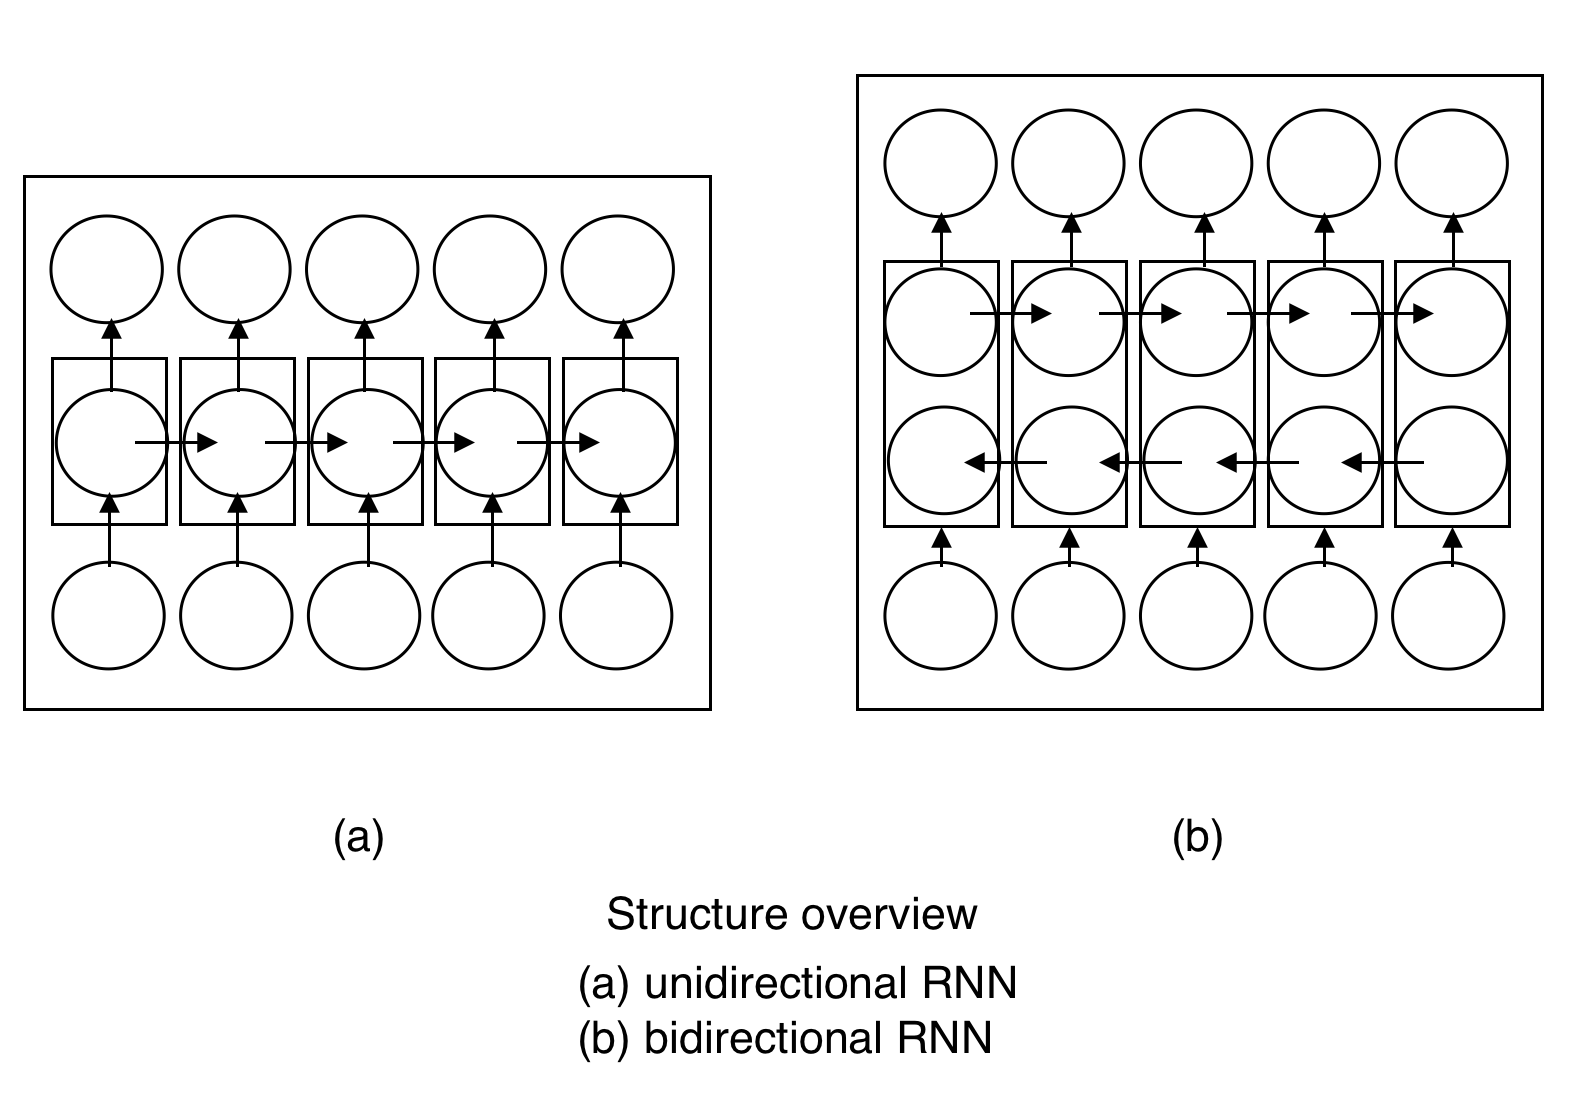

In [ ]:
## Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_4_embedding = layers.Embedding(input_dim = max_vocab_length,
                                     output_dim = 128,
                                     embeddings_initializer = 'uniform',
                                     input_length = max_length,
                                     name = 'embeddings_4')

# Build a Bidirection RNN model in tensorflow
inputs = layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = model_4_embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x) # stacking RNN layers requires return sequences=True
x = layers.Bidirectional(layers.LSTM(64))(x) #Bidirectional goes both way so has double the parameter as the regular one
outputs = layers.Dense(1, activation='sigmoid')(x)
model_4 = tf.keras.Model(inputs, outputs, name='model_4_Bidirectional')


  🔑**Note**: Now we can create and use the Bidirectional wrapper on any RNN cell in tensorflow. For example,

` layers.Bidirectional(layers.GRU(64))`
creates a bidirectional GRU cell

In [ ]:
# COmpile the model_4 i.e Bidirectional RNN model
model_4.compile(loss = 'binary_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])


In [ ]:
# Get a summary of Bidirectional RNN i.e model_4
model_4.summary()


Model: "model_4_Bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embeddings_4 (Embedding)    (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,378,945
Trainable params: 1,3

In [ ]:
# Fit the model (takes longer because of the bidirectional layer)
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks = [create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                       experiment_name = 'bidirectional_RNN')])


Saving TensorBoard log files to: /content/drive/MyDrive/Introduction_to_NLP_in_DeepLearning/model_logs/bidirectional_RNN/20230304-021752
Epoch 1/5
215/215 [==============================] - 17s 48ms/step - loss: 0.5076 - accuracy: 0.7462 - val_loss: 0.4599 - val_accuracy: 0.7835
Epoch 2/5
215/215 [==============================] - 4s 18ms/step - loss: 0.3124 - accuracy: 0.8720 - val_loss: 0.5253 - val_accuracy: 0.7717
Epoch 3/5
215/215 [==============================] - 3s 12ms/step - loss: 0.2111 - accuracy: 0.9183 - val_loss: 0.5735 - val_accuracy: 0.7677
Epoch 4/5
215/215 [==============================] - 2s 10ms/step - loss: 0.1462 - accuracy: 0.9505 - val_loss: 0.6535 - val_accuracy: 0.7808
Epoch 5/5
215/215 [==============================] - 2s 11ms/step - loss: 0.1028 - accuracy: 0.9667 - val_loss: 0.7090 - val_accuracy: 0.7638


In [ ]:
# Make prediction (returned as probablities) with the Bidirectional RNN on the validation data
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs.shape, model_4_pred_probs[:5] # view the first 5 tweet's prediction probablity


24/24 [==============================] - 1s 4ms/step


((762, 1), array([[0.03785439],
        [0.9164724 ],
        [0.9994785 ],
        [0.19290827],
        [0.00485274]], dtype=float32))

In [ ]:
# Convert prediction probablities into labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:5] # view the first 5 prediction classes of the model 4 on first 5 tweets


<tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 1., 1., 0., 0.], dtype=float32)>

In [ ]:
# Calculate bidirectional RNN model results
model_4_results = calculate_results(val_labels, model_4_preds)
model_4_results


{'accuracy': 76.37795275590551,
 'precision': 0.763377762834769,
 'recall': 0.7637795275590551,
 'f1': 0.7633188054110939}

### Comparing the results to the baseline model

In [ ]:
# Compare the model_4 i.e. Bidirectional-RNN model to the baseline model results
compare_baseline_to_new_results(baseline_results = baseline_results,
                                new_model_results = model_4_results)


Bseline accuracy: 79.27, New accuracy: 76.38, Difference: -2.89
Bseline precision: 0.81, New precision: 0.76, Difference: -0.05
Bseline recall: 0.79, New recall: 0.76, Difference: -0.03
Bseline f1: 0.79, New f1: 0.76, Difference: -0.02


## **Model 5**: Conv1D model (1D Convolutional Neural Network)

We had used COnvolutional Neural Naetwork (CNN) previously for image classification.

The main difference between using CNNs for images and sequences is the hsape of the data. Images are 2D (height X Width) whereas strings are often 1D (a string of text).

So to use CNNs with sequences, we use 1D convolution instead of a 2D-convolution.

A typical CNN archtecture for the sequence data look like the following:

 `Inputs --> Tokenizaition --> Embedding --> Layers --> Outputs (Class Probablitites)`

 The difference is in the layers component. Instead of using an LSTM or GRU cell, we are going to use a tensorflow.keras.layers.COnv1D() layer followed by a tensorflow.keras.layers.GlobalMaxPool1D() layer.

  

  ◾  **Resource**: The intiution here is explained succinclty in the paper *Understanding Convolutional Neural Networks for Text Classification*, where they state that CNNs classify text through the following steprs:

    1. 1-D convolving filters are used as ngrams (an ngram is a collection of n-words, for example, an ngram of 5 might result in "hello, my name's Daniel".)
    2. Max-pooling over time extracts the relevant ngrams for making a decision.
    3. The rest of the netwrok classifies the texts based on thos information.

🔑 **Tensor Flow Official Documentation:** [ TF Keras Conv 1D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D
)



### CNN Model (Conv1D for text)

In [ ]:
# Test the embedding, 1D Convolutional and max pooling

embedding_test = embedding(text_vectorizer(["this is a test sentence"])) # turn target sentence into embedding

conv_1d = layers.Conv1D(filters=32,
                        kernel_size=5, # convolve over target sequence 5 words at a time
                        activation="relu",
                        padding="valid") # 'valid':output is smaller than the input shape, 'same': o/p same as i/p shape

conv_1d_output = conv_1d(embedding_test) #pass embedding through 1D convolutional layer
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output) # get the most important features
embedding_test.shape, conv_1d_output.shape, max_pool_output.shape



(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

**Output Shapes of each layer:** The embedding has an output shape dimension of the parameters we set it to (input_length=15 and output_dim=128)

The 1-Dimensional layer has an output which has been compressed inline with its parameters. And the same goes for the max pooling layer output.

Our text starts out as a string but gets converted to a feature vector of length 32 through various transformation steps (from tokenization to embedding to 1-Dimensional convolution to max_pool)

**Resources**:
1. Stride Length and parameters: [CNN Explainer](https://poloclub.github.io/cnn-explainer/). The CNN explianer is for 2-D but the main premises remains the pretty much the same for Conv-1D. The 'Understanding Hyperparameters section shows the 2D animation but the concepts remain the same for Conv1D too with just only the top row alone. Since the kernal siz is 5, it looks at 5 words at a time (5 boxes in the top row). SInce the stride is 1, it will move to the second box after reading the first 5 words.
2. Padding : [Stack overflow explanation of valid and same padding differences](https://stackoverflow.com/questions/37674306/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-t#:~:text=To%20sum%20up%2C%20'valid',same'%20padding%20means%20using%20padding. )
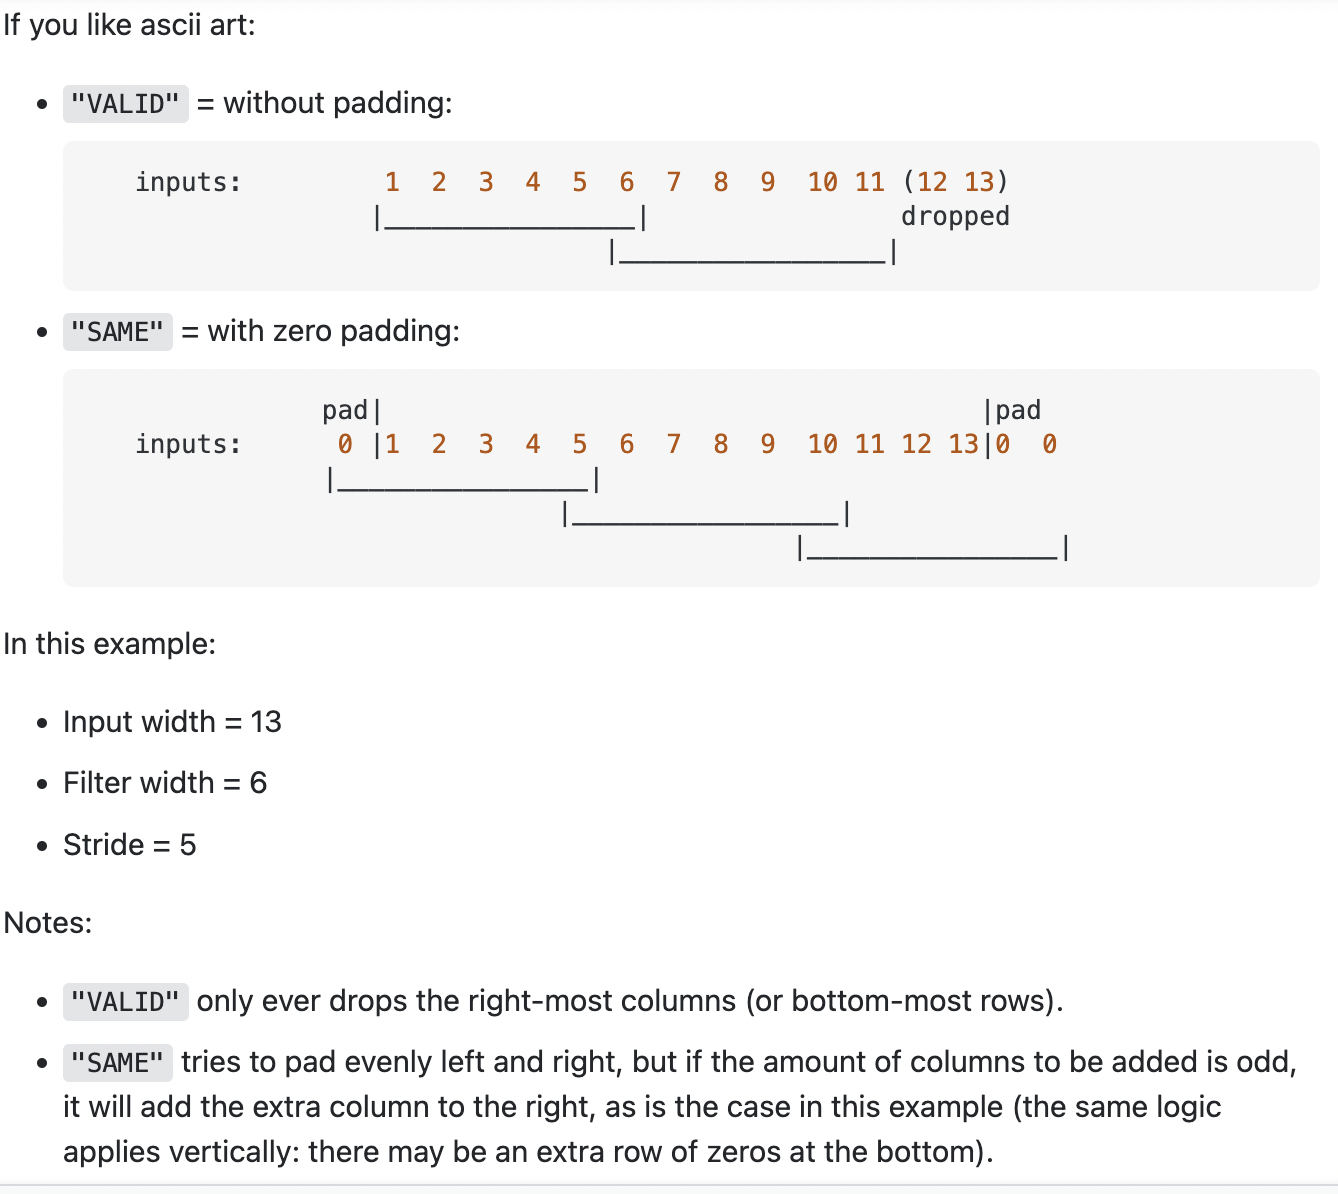

In [ ]:
# See the outputs of each layer

embedding_test[:1], conv_1d_output[:1], max_pool_output[:1]

(<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
 array([[[-0.02841682, -0.010473  ,  0.02090074, ..., -0.02112441,
          -0.02972552, -0.04258378],
         [-0.01354263,  0.02169218,  0.0203194 , ..., -0.03776067,
           0.03121694, -0.07157604],
         [ 0.00344717,  0.03514952,  0.00549325, ..., -0.01906109,
          -0.02565462, -0.0561992 ],
         ...,
         [-0.05360993,  0.04328285,  0.02862227, ...,  0.02684987,
           0.02318122, -0.05034778],
         [-0.05360993,  0.04328285,  0.02862227, ...,  0.02684987,
           0.02318122, -0.05034778],
         [-0.05360993,  0.04328285,  0.02862227, ...,  0.02684987,
           0.02318122, -0.05034778]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 11, 32), dtype=float32, numpy=
 array([[[0.02708301, 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.04450314, 0.        ,
          0.        , 0.        , 0.00330404, 0.01849075, 0.        ,
          0.02280126, 0.

Now that we have explored the ouputs of several components of a CNN for sequences, we can bring them togather and construct a full model, compile it and get a summary.

In [ ]:
from keras.optimizers.optimizer_experimental import optimizer
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_5_embedding = layers. Embedding(input_dim= max_vocab_length,
                                      output_dim=128,
                                      embeddings_initializer='uniform',
                                      input_length = max_length,
                                      name='embedding_5')

# Create 1-dimensional convolutional layer to model sequences
inputs = layers.Input(shape=(1,),dtype="string")
x = text_vectorizer(inputs)
x = model_5_embedding(x)
x = layers.Conv1D(filters=32, kernel_size=5, activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
#x = layers.Dense(64,activation='relu')(x) # Optional dense layer
outputs = layers.Dense(1, activation='sigmoid')(x)
model_5 = tf.keras.Model(inputs, outputs, name='model_5_Conv1D')

# Compile Conv1D model
model_5.compile(loss= 'binary_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Get a summary
model_5.summary()



Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_5 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 conv1d_5 (Conv1D)           (None, 11, 32)            20512     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_9 (Dense)             (None, 1)              

In [ ]:
# Fit the model
model_5_history= model_5.fit(train_sentences,
                             train_labels,
                             epochs=5,
                             validation_data=(val_sentences, val_labels),
                             callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                    'Conv1D')])


Saving TensorBoard log files to: /content/drive/MyDrive/Introduction_to_NLP_in_DeepLearning/model_logs/Conv1D/20230304-022529
Epoch 1/5
215/215 [==============================] - 12s 40ms/step - loss: 0.5645 - accuracy: 0.7154 - val_loss: 0.4707 - val_accuracy: 0.7835
Epoch 2/5
215/215 [==============================] - 2s 10ms/step - loss: 0.3392 - accuracy: 0.8602 - val_loss: 0.4687 - val_accuracy: 0.7940
Epoch 3/5
215/215 [==============================] - 2s 9ms/step - loss: 0.2108 - accuracy: 0.9216 - val_loss: 0.5297 - val_accuracy: 0.7730
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.1367 - accuracy: 0.9555 - val_loss: 0.6013 - val_accuracy: 0.7769
Epoch 5/5
215/215 [==============================] - 3s 12ms/step - loss: 0.0964 - accuracy: 0.9669 - val_loss: 0.6558 - val_accuracy: 0.7861


In [ ]:
# Make Predictions with model_5
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

24/24 [==============================] - 0s 3ms/step


array([[0.7436218 ],
       [0.79654783],
       [0.9998815 ],
       [0.15812905],
       [0.00210207],
       [0.99731416],
       [0.91342866],
       [0.997867  ],
       [0.9996363 ],
       [0.37781683]], dtype=float32)

In [ ]:
# Convert model_5 prediction probablitites to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))

In [ ]:
# Calculate model_5 evaluation metrics
model_5_results = calculate_results(y_true = val_labels,
                                    y_pred = model_5_preds)
model_5_results

{'accuracy': 78.60892388451444,
 'precision': 0.7885525005575463,
 'recall': 0.7860892388451444,
 'f1': 0.7839649054352522}

### Comparing the results to Baseline

In [ ]:
# Compare model_5 results to baseline
compare_baseline_to_new_results(baseline_results, model_5_results)

Bseline accuracy: 79.27, New accuracy: 78.61, Difference: -0.66
Bseline precision: 0.81, New precision: 0.79, Difference: -0.02
Bseline recall: 0.79, New recall: 0.79, Difference: -0.01
Bseline f1: 0.79, New f1: 0.78, Difference: -0.00


# Using Pretrained Embeddings (Transfer Learning for NLP)

Until now, we had created and used our own embeddings from scratch.

However, a common practice is to leverage pretrained embeddings through **transfer learning**. This is one of the main benefits of using deep models: being able to take what one (often larger) model has leanred (often on a large amount of data) and adjust it for our own use case.

In the upcoming models,we would be using a pretrined embedding layer that replaces the embedding layer that we build.

For model 6 we would be using the Universal Sentence Encoder from TensorFlow Hub (a great resource that contains a plethora of pretrained model resources from a variety of tasks).

  🔑 **NOTE**: There are many pretrianed text embedding options on the TensorFlow Hub, however, some require different levels of text preprocessing than others.

## Model 6: Tensor Flow Hub Pretrained Sentence Encoder

The main difference the embedding layer we created and the universal Sentence Encoder is that rather than create a word-level embedding, the Universal Sentence Encoder, creates a whole sentence-level embedding.

Our embedding layer outputs a 128 dimensional vector, whereas, the Universal Sentence Encoder outputs a 512 dimensional vector for each sentence.

**IMPORTANT**: We can load the TensorFLow Hub module using the hub.load() method and passing it the target URL of the module we would like to use, which in our case is ["https://tfhub.dev/google/ujniversal-sentence-encoder/4"].

Let us load the Universal Sentence ENcoder model and test it on a couple of sentences.

In [ ]:
# Example of pretrained embedding with Universal sentence encoder
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4") # Load Universal Sentence Encoder
embed_samples = embed([sample_sentence,
                       "When you call the universal sentence encoder on a sentence, it turns it into numbers."])
print(embed_samples[0][:50])

tf.Tensor(
[ 0.00555437  0.06127657  0.00942083  0.01102346  0.0314914   0.03249596
  0.0166631  -0.00258187 -0.01000023 -0.03956292  0.00052715  0.00178267
  0.02745149  0.12330879 -0.028594   -0.05160445 -0.03247536 -0.0260081
 -0.02609756 -0.08984502 -0.01180509 -0.01729041  0.01232958 -0.00683744
 -0.0385328  -0.02969585  0.06090548 -0.01704141 -0.04036641  0.04523545
 -0.02638779  0.05424506  0.02299915  0.05435755  0.02103578 -0.02563776
  0.02742162  0.05287186 -0.0729065  -0.0671038   0.0153477   0.01449496
 -0.03901767  0.07266098 -0.11199063 -0.06227372 -0.03845942 -0.05642945
  0.03120597  0.00493896], shape=(50,), dtype=float32)


In [ ]:
# Each sentence has been encoded into a 512 dimension
embed_samples[0].shape

TensorShape([512])

So, we see that passing our Sentences through the Universal Sentence Encoder(USE) encodes them from strings to 512 dimensional vector.

We can now build model with the USE embedding layer.

We can convert the TensorFlow Hub USE module into a keras layers using the `hub.KerasLayer` class.

  🔑 **NOTE**: Due to the size of the USE TensorFLow Hub module, it may take a little while to download. Once it's downloaded though, it will be chached and ready to use. Similar to may TensorFlow Hub modules, there is a "lite" version of the USE which takes up less space but sacrifices some performance and requires more preprocessing steps. However, depending on your compute power, the lite may be better for some application use case.

In [ ]:
# Use of this embedding layer in place of our text_vectorizer and embedding layer

sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], # shape of inputs coming model
                                        dtype = tf.string, # data type of inputs coming to the USE layer
                                        trainable = False, # Keep the pretrained weights
                                        name = "USE")
print(embed_samples[0][:50])

tf.Tensor(
[ 0.00555437  0.06127657  0.00942083  0.01102346  0.0314914   0.03249596
  0.0166631  -0.00258187 -0.01000023 -0.03956292  0.00052715  0.00178267
  0.02745149  0.12330879 -0.028594   -0.05160445 -0.03247536 -0.0260081
 -0.02609756 -0.08984502 -0.01180509 -0.01729041  0.01232958 -0.00683744
 -0.0385328  -0.02969585  0.06090548 -0.01704141 -0.04036641  0.04523545
 -0.02638779  0.05424506  0.02299915  0.05435755  0.02103578 -0.02563776
  0.02742162  0.05287186 -0.0729065  -0.0671038   0.0153477   0.01449496
 -0.03901767  0.07266098 -0.11199063 -0.06227372 -0.03845942 -0.05642945
  0.03120597  0.00493896], shape=(50,), dtype=float32)


Now we have the USE as a keras layer, we can use it in Keras sequential model.

In [ ]:
# Create model using the Sequential API

model_6 = tf.keras.Sequential(
                              [sentence_encoder_layer,
                               layers.Dense(64, activation= 'relu'),
                               layers.Dense(1, activation="sigmoid")],
                               name = 'model_6_USE')

# Compile model
model_6.compile(loss="binary_crossentropy",
               optimizer = tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_3 (Dense)             (None, 64)                32832     
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


Notice the number of parameters in the USE layer, these are the pretrained weights it has learned on various text sources (WIkipedia, web news, web question-answer forum, etc, see the Universal Sentence Encoder paper for more).

The trianable parameters are only in our output layers, in other words, we are keeping the USE weights frozen and using it as a feature-extractor. We could fine-tune these weights by `trainable=True` when creating `hub.KerasLayer` instance.

Now we have got a feature extractor model ready, let's train it and track its results to the TensorBoard using our create_tensorboard_callback() function.


In [ ]:
# Train a classifier on top of pretrained embeddings

model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs= 5,
                              validation_data = (val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "tf_hub_sentence_encoder")]
                              )

Saving TensorBoard log files to: /content/drive/MyDrive/Introduction_to_NLP_in_DeepLearning/model_logs/tf_hub_sentence_encoder/20230304-022852
Epoch 1/5
215/215 [==============================] - 9s 22ms/step - loss: 0.5014 - accuracy: 0.7882 - val_loss: 0.4460 - val_accuracy: 0.8018
Epoch 2/5
215/215 [==============================] - 3s 13ms/step - loss: 0.4147 - accuracy: 0.8136 - val_loss: 0.4348 - val_accuracy: 0.8163
Epoch 3/5
215/215 [==============================] - 3s 13ms/step - loss: 0.3999 - accuracy: 0.8213 - val_loss: 0.4308 - val_accuracy: 0.8136
Epoch 4/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3923 - accuracy: 0.8257 - val_loss: 0.4269 - val_accuracy: 0.8202
Epoch 5/5
215/215 [==============================] - 4s 20ms/step - loss: 0.3858 - accuracy: 0.8282 - val_loss: 0.4294 - val_accuracy: 0.8123


In [ ]:
# Make predictions with USE TF Hub model

model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

24/24 [==============================] - 1s 10ms/step


array([[0.16296208],
       [0.73966384],
       [0.98869145],
       [0.20715514],
       [0.74387187],
       [0.6885952 ],
       [0.9814617 ],
       [0.9760492 ],
       [0.9217777 ],
       [0.09360487]], dtype=float32)

In [ ]:
# Convert prediction probablitties to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Calculate model 6 performance metrics
model_6_results = calculate_results(val_labels, model_6_preds)
model_6_results

{'accuracy': 81.23359580052494,
 'precision': 0.8148798668657973,
 'recall': 0.8123359580052494,
 'f1': 0.810686575717776}

### Comparing the results to the baseline

In [ ]:
# Compare USE model from the tf hub to the baseline
compare_baseline_to_new_results(baseline_results, model_6_results)

Bseline accuracy: 79.27, New accuracy: 81.23, Difference: 1.97
Bseline precision: 0.81, New precision: 0.81, Difference: 0.00
Bseline recall: 0.79, New recall: 0.81, Difference: 0.02
Bseline f1: 0.79, New f1: 0.81, Difference: 0.02


## Model 7: BERT Family Pretrained Encoders

In [ ]:
!pip install tensorflow_text
import tensorflow_text as text  # Registers the ops.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 40.4 MB/s eta 0:00:00


In [ ]:
# Example of preprocessor
import tensorflow_hub as hub
preprocessor = hub.load("https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3") # Load Universal Sentence Encoder
preprocess_sample = preprocessor([sample_sentence,
                       "When you call the universal sentence encoder on a sentence, it turns it into numbers."])
print(preprocess_sample)

NameError: ignored

In [ ]:
bert_preprocess_model = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3")

In [ ]:
# Load the required BERT model
embed_bert = hub.load("https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/4")

embed_bert_model = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/4",
                                        input_shape=[], # shape of inputs coming model
                                        dtype = tf.int32, # data type of inputs coming to the USE layer
                                        trainable = False, # Keep the pretrained weights
                                        name = "BERTBase")

In [ ]:
from transformers import TFBertModel, BertConfig

In [ ]:
bert_model = TFBertModel.from_pretrained('bert-base-cased') # bert base model with pretrained weights
input_ids = tf.keras.layers.Input(shape=(128,), name='input_ids', dtype='int32')
attn_masks = tf.keras.layers.Input(shape=(128,), name='attention_mask', dtype='int32')
bert_embds = bert_model.bert(input_ids, attention_mask=attn_masks)[1]
intermediate_layer = tf.keras.layers.Dense(128, activation='relu', name='intermediate_layer1')(bert_embds)
intermediate_layer = tf.keras.layers.Dropout(0.3)(intermediate_layer)
intermediate_layer = tf.keras.layers.Dense(256, activation='relu', name='intermediate_layer2')(intermediate_layer)
intermediate_layer = tf.keras.layers.Dropout(0.3)(intermediate_layer)
intermediate_layer = tf.keras.layers.Dense(128, activation='relu', name='intermediate_layer3')(intermediate_layer)
intermediate_layer = layers.Dense(64,activation='relu')(intermediate_layer) # Optional dense layer
outputs = layers.Dense(1, activation='sigmoid')(intermediate_layer)

In [ ]:
model_7 = tf.keras.Model(inputs=[input_ids, attn_masks], outputs=outputs, name='model_7_BertBase')
# Compile Conv1D model
model_7.compile(loss= 'binary_crossentropy',
                optimizer = tf.keras.optimizers.Adam(lr=1e-5),
                metrics=['accuracy'])

# Get a summary
model_7.summary()

Model: "model_7_BertBase"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                       

In [ ]:
# Fit the model
model_7_history= model_7.fit(train_sentences,
                             train_labels,
                             epochs=5,
                             validation_data=(val_sentences, val_labels),
                             callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                    'BertBase')])

Saving TensorBoard log files to: /content/drive/MyDrive/Introduction_to_NLP_in_DeepLearning/model_logs/BertBase/20230307-131504
Epoch 1/5
183/215 [========================>.....] - ETA: 10s - loss: 0.6878 - accuracy: 0.5574

KeyboardInterrupt: ignored

In [ ]:
# Make predictions with BERT Uncased model

model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

In [ ]:
# Convert prediction probablities to labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

In [ ]:
# Calculate model 7 performance metrics
model_7_results = calculate_results(val_labels, model_7_preds)
model_7_results

### Comparing BERT Uncased model to the baseline

In [ ]:
# Compare USE model from the tf hub to the baseline
compare_baseline_to_new_results(baseline_results, model_7_results)

## Model 7b: AlBert Model

In [ ]:
bert_preprocess_model = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
embed_bert_model = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_cased_L-24_H-1024_A-16/4",
                                        input_shape=[], # shape of inputs coming model
                                        dtype = tf.int32, # data type of inputs coming to the USE layer
                                        trainable = False, # Keep the pretrained weights
                                        name = "ALBERTBase")

In [ ]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers

# Create base bert to model sequences
inputs = layers.Input(shape=(),dtype="string",name='text')
x = bert_preprocess_model(inputs)
x = embed_bert_model(x)

x = layers.Dense(64,activation='relu')(x['pooled_output']) # Optional dense layer
outputs = layers.Dense(1, activation='sigmoid')(x)
model_7_b = tf.keras.Model(inputs, outputs, name='model_7_ALBertBase')

# Compile Conv1D model
model_7_b.compile(loss= 'binary_crossentropy',
                optimizer = tf.keras.optimizers.Adam(lr=1e-4),
                metrics=['accuracy'])

# Get a summary
model_7_b.summary()



Model: "model_7_ALBertBase"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer_10 (KerasLayer)    {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                     

In [ ]:
# Fit the model
model_7_b_history= model_7_b.fit(train_sentences,
                             train_labels,
                             epochs=10,
                             validation_data=(val_sentences, val_labels),
                             callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                    'ALBertBase')])

Saving TensorBoard log files to: /content/drive/MyDrive/Introduction_to_NLP_in_DeepLearning/model_logs/ALBertBase/20230304-054825
Epoch 1/10
215/215 [==============================] - 93s 387ms/step - loss: 0.5948 - accuracy: 0.6954 - val_loss: 0.5739 - val_accuracy: 0.6969
Epoch 2/10
215/215 [==============================] - 81s 376ms/step - loss: 0.5694 - accuracy: 0.7183 - val_loss: 0.6481 - val_accuracy: 0.7034
Epoch 3/10
215/215 [==============================] - 79s 367ms/step - loss: 0.5437 - accuracy: 0.7393 - val_loss: 0.5494 - val_accuracy: 0.7152
Epoch 4/10
215/215 [==============================] - 81s 375ms/step - loss: 0.5350 - accuracy: 0.7405 - val_loss: 0.5260 - val_accuracy: 0.7349
Epoch 5/10
215/215 [==============================] - 81s 378ms/step - loss: 0.5279 - accuracy: 0.7504 - val_loss: 0.5286 - val_accuracy: 0.7297
Epoch 6/10
215/215 [==============================] - 81s 376ms/step - loss: 0.5192 - accuracy: 0.7529 - val_loss: 0.5094 - val_accuracy: 0.7507


In [ ]:
# Make predictions with AlBert model

model_7_b_pred_probs = model_7_b.predict(val_sentences)
model_7_b_pred_probs[:10]

In [ ]:
# Convert prediction probablities to labels
model_7_b_preds = tf.squeeze(tf.round(model_7_b_pred_probs))
model_7_b_preds[:10]

In [ ]:
# Calculate model 7 performance metrics
model_7_b_results = calculate_results(val_labels, model_7_b_preds)
model_7_b_results

### Comparing the AlBERT results to the baseline


In [ ]:
# Compare AlBert model to the baseline
compare_baseline_to_new_results(baseline_results, model_7_b_results)

## Model 8: DistilBERT with bi-LSTM

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 78.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 115.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 24.3 MB/s eta 0:00:00


In [ ]:
import transformers
from transformers import AutoTokenizer, TFAutoModel
from transformers import AutoConfig, AutoModel

In [ ]:
dtbert_preprocess_model = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
embed_dtbert_model = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_cased_L-24_H-1024_A-16/4",
                                        input_shape=[], # shape of inputs coming model
                                        dtype = tf.int32, # data type of inputs coming to the USE layer
                                        trainable = False, # Keep the pretrained weights
                                        name = "DistilBERT")

In [ ]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers

# Create DistilBert-BiLSTM to model sequences
inputs = layers.Input(shape=(),dtype="string",name='text')
x = dtbert_preprocess_model(inputs)
x = embed_dtbert_model(x)
x = layers.Bidirectional(layers.LSTM(64))(x) # Bi-LSTM Layer
x = layers.Dense(64,activation='relu')(x['pooled_output']) # Optional dense layer
outputs = layers.Dense(1, activation='sigmoid')(x)
model_8 = tf.keras.Model(inputs, outputs, name='model_7_ALBertBase')

# Compile DistilBert-BiLSTM model
model_8.compile(loss= 'binary_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Get a summary
model_8.summary()

In [ ]:
# Fit the model
model_8_history= model_8.fit(train_sentences,
                             train_labels,
                             epochs=10,
                             validation_data=(val_sentences, val_labels),
                             callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                    'ALBertBase')])

In [ ]:
# Make predictions with AlBert model

model_8_pred_probs = model_8.predict(val_sentences)
model_8_pred_probs[:10]

In [ ]:
# Convert prediction probablities to labels

model_8_preds = tf.squeeze(tf.round(model_8_pred_probs))
model_8_preds[:10]

In [ ]:
# Calculate model 8 performance metrics
model_8_results = calculate_results(val_labels, model_8_preds)
model_8_results

### Comparing the DistilBERT results to the Baseline

In [ ]:
# Compare AlBert model from the tf hub to the baseline
compare_baseline_to_new_results(baseline_results, model_8_results)

## Model 9: Glove Embeding

In [ ]:
# Creatting EMbedding dictionary using GloVe Vectorizer
import numpy as np

embeddings_dictionary = dict()

embedding_dim = 100

glove_file = open('/content/drive/MyDrive/Introduction_to_NLP_in_DeepLearning/glove.6B.100d.txt')

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions

glove_file.close()


In [ ]:
from keras.preprocessing.text import Tokenizer
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(train_df_shuffled['text'].values)
vocab_length = len(word_tokenizer.word_index) + 1

In [ ]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
def embed(corpus):
    return word_tokenizer.texts_to_sequences(corpus)

longest_train = max(train_df_shuffled['text'].values, key=lambda sentence: len(word_tokenize(sentence)))

length_long_sentence = len(word_tokenize(longest_train))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
!pip install keras_preprocessing
from keras_preprocessing.sequence import pad_sequences

padded_sentences = pad_sequences(embed(train_df_shuffled['text'].values),
                                 length_long_sentence, padding='post')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Creating Word Embedding matrix which is a list of all words and their corresponding embeddings.

embedding_matrix = np.zeros((vocab_length, embedding_dim))

for word, index in word_tokenizer.word_index.items():

    embedding_vector = embeddings_dictionary.get(word)

    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector


In [ ]:
train_glove, val_glove, train_labels, val_labels = train_test_split(padded_sentences, # function expects an numpy array
                                                                            train_df_shuffled['target'].to_numpy(), # use pandas to_numpy method to convert df to np array
                                                                            test_size= 0.1, # use 10% of data for validation set
                                                                            random_state=42)

In [ ]:
# create the embedding layer
from tensorflow.keras import layers

In [ ]:
# Create Glove embedding 1-dimensional convolutional layer to model sequences
inputs = layers.Input(shape=(length_long_sentence,))
GloVe_embedding = layers.Embedding(input_dim=vocab_length, # input shape
                             output_dim=embedding_dim, # output shape: multiples of 8 speeds up the process
                             weights=[embedding_matrix], # GloVe Embedding
                             embeddings_initializer='uniform',
                             input_length=length_long_sentence # length of each input
                             )
# x = text_vectorizer(inputs)
x = GloVe_embedding(inputs)
x = layers.Conv1D(filters=32, kernel_size=5, activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
#x = layers.Dense(64,activation='relu')(x) # Optional dense layer
outputs = layers.Dense(1, activation='sigmoid')(x)
model_9 = tf.keras.Model(inputs, outputs, name='model_9_GloVe_Conv1D')

# Compile Glove-Conv1D model
model_9.compile(loss= 'binary_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Get a summary
model_9.summary()


Model: "model_9_GloVe_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 72)]              0         
                                                                 
 embedding (Embedding)       (None, 72, 100)           2270100   
                                                                 
 conv1d (Conv1D)             (None, 68, 32)            16032     
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 2,286,165
Trainable params: 2,286,165
Non-trainable params: 0
____________________________________

In [ ]:
# Fit the model

model_9_history= model_9.fit(train_glove,
                             train_labels,
                             epochs=10,
                             validation_data=(val_glove, val_labels),
                             callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                    'GloVe')])

Saving TensorBoard log files to: /content/drive/MyDrive/Introduction_to_NLP_in_DeepLearning/model_logs/GloVe/20230304-093518
Epoch 1/10
215/215 [==============================] - 18s 66ms/step - loss: 0.4938 - accuracy: 0.7681 - val_loss: 0.4658 - val_accuracy: 0.7966
Epoch 2/10
215/215 [==============================] - 4s 21ms/step - loss: 0.3432 - accuracy: 0.8600 - val_loss: 0.4484 - val_accuracy: 0.7992
Epoch 3/10
215/215 [==============================] - 3s 13ms/step - loss: 0.2532 - accuracy: 0.9064 - val_loss: 0.4524 - val_accuracy: 0.8097
Epoch 4/10
215/215 [==============================] - 3s 15ms/step - loss: 0.1851 - accuracy: 0.9380 - val_loss: 0.4627 - val_accuracy: 0.7900
Epoch 5/10
215/215 [==============================] - 2s 9ms/step - loss: 0.1246 - accuracy: 0.9645 - val_loss: 0.4844 - val_accuracy: 0.7913
Epoch 6/10
215/215 [==============================] - 2s 10ms/step - loss: 0.0811 - accuracy: 0.9783 - val_loss: 0.5093 - val_accuracy: 0.8084
Epoch 7/10
215/21

In [ ]:
# Make predictions with GloVe-Conv1D model

model_9_pred_probs = model_9.predict(val_glove)
model_9_pred_probs[:10]

24/24 [==============================] - 1s 9ms/step


array([[0.26867074],
       [0.6843076 ],
       [0.99998736],
       [0.02600677],
       [0.25188893],
       [0.9714858 ],
       [0.9904028 ],
       [0.99974483],
       [0.99898773],
       [0.07638114]], dtype=float32)

In [ ]:
# Convert prediction probablities to labels

model_9_preds = tf.squeeze(tf.round(model_9_pred_probs))
model_9_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Calculate model 9 performance metrics
model_9_results = calculate_results(val_labels, model_9_preds)
model_9_results

{'accuracy': 79.65879265091863,
 'precision': 0.797940426545891,
 'recall': 0.7965879265091863,
 'f1': 0.7951255938957291}

### Comparing the results of GloVe embedding-Conv1D model with baseline

In [ ]:
# Compare GloVe Embedding Conv1D model to the baseline
compare_baseline_to_new_results(baseline_results, model_9_results)

Bseline accuracy: 79.27, New accuracy: 79.66, Difference: 0.39
Bseline precision: 0.81, New precision: 0.80, Difference: -0.01
Bseline recall: 0.79, New recall: 0.80, Difference: 0.00
Bseline f1: 0.79, New f1: 0.80, Difference: 0.01


## Model 10: Glove Embedding with Bi-LSTM

In [ ]:
# create the embedding layer
GloVe_lstmb_embedding = layers.Embedding(input_dim=vocab_length, # input shape
                             output_dim=embedding_dim, # output shape: multiples of 8 speeds up the process
                             weights=[embedding_matrix], # GloVe Embedding
                             embeddings_initializer='uniform',
                             input_length=length_long_sentence # length of each input
                             )

# Build a GloVe-Bidirection RNN model in tensorflow
inputs = layers.Input(shape=(length_long_sentence,))
# x = text_vectorizer(inputs)
x = GloVe_lstmb_embedding(inputs)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x) # stacking RNN layers requires return sequences=True
x = layers.Bidirectional(layers.LSTM(64))(x) #Bidirectional goes both way so has double the parameter as the regular one
outputs = layers.Dense(1, activation='sigmoid')(x)
model_10 = tf.keras.Model(inputs, outputs, name='model_10_GloVe_BiLSTM')

# Compile Conv1D model
model_10.compile(loss= 'binary_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Get a summary
model_10.summary()



Model: "model_10_GloVe_BiLSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 72)]              0         
                                                                 
 embedding_3 (Embedding)     (None, 72, 100)           2270100   
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              84480     
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2,354,709
Trainable params: 2,354,709
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Fit the model
model_10_history= model_10.fit(train_glove,
                             train_labels,
                             epochs=10,
                             validation_data=(val_glove, val_labels),
                             callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                    'GloVe LSTM')])

Saving TensorBoard log files to: /content/drive/MyDrive/Introduction_to_NLP_in_DeepLearning/model_logs/GloVe LSTM/20230304-094359
Epoch 1/10
215/215 [==============================] - 20s 65ms/step - loss: 0.4723 - accuracy: 0.7881 - val_loss: 0.4729 - val_accuracy: 0.7992
Epoch 2/10
215/215 [==============================] - 5s 23ms/step - loss: 0.3583 - accuracy: 0.8529 - val_loss: 0.4494 - val_accuracy: 0.8031
Epoch 3/10
215/215 [==============================] - 4s 18ms/step - loss: 0.2684 - accuracy: 0.8943 - val_loss: 0.4610 - val_accuracy: 0.8031
Epoch 4/10
215/215 [==============================] - 3s 14ms/step - loss: 0.1484 - accuracy: 0.9447 - val_loss: 0.5425 - val_accuracy: 0.8031
Epoch 5/10
215/215 [==============================] - 3s 13ms/step - loss: 0.0661 - accuracy: 0.9765 - val_loss: 0.7581 - val_accuracy: 0.7900
Epoch 6/10
215/215 [==============================] - 2s 11ms/step - loss: 0.0358 - accuracy: 0.9882 - val_loss: 0.8197 - val_accuracy: 0.7848
Epoch 7/10


In [ ]:
# Make predictions with GloVe-BiLSTM model

model_10_pred_probs = model_10.predict(val_glove)
model_10_pred_probs[:10]

24/24 [==============================] - 0s 8ms/step


array([[7.2026633e-05],
       [3.3550137e-03],
       [9.9987030e-01],
       [1.4022075e-02],
       [9.9946707e-01],
       [7.9973853e-01],
       [9.9818963e-01],
       [9.9994016e-01],
       [9.9975759e-01],
       [8.8800862e-02]], dtype=float32)

In [ ]:
# Convert prediction probablities to labels

model_10_preds = tf.squeeze(tf.round(model_10_pred_probs))
model_10_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Calculate model 10 performance metrics
model_10_results = calculate_results(val_labels, model_10_preds)
model_10_results

{'accuracy': 78.87139107611549,
 'precision': 0.7987731870594826,
 'recall': 0.7887139107611548,
 'f1': 0.7842136854361449}

### Comparing the results of GloVe EMbedding with BiLSTM to baseline model

In [ ]:
# Compare Glove embedding biLSTM model to the baseline
compare_baseline_to_new_results(baseline_results, model_10_results)

Bseline accuracy: 79.27, New accuracy: 78.87, Difference: -0.39
Bseline precision: 0.81, New precision: 0.80, Difference: -0.01
Bseline recall: 0.79, New recall: 0.79, Difference: -0.00
Bseline f1: 0.79, New f1: 0.78, Difference: -0.00
